<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/ClassificationTestes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import random
from collections import Counter
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

### Algoritmos

In [35]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    X_columns = dataframe.columns[dataframe.columns != 'Classe']
    X = dataframe[X_columns]
    Y = dataframe['Classe']

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [36]:
def BlockSplit0(dataframe, n_splits, seed, n_songs):

  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  test_list = []
  definitive_test_list = []


  for i in range(10):
    r = random.sample(range(i*songs_per_genre, (i+1)*songs_per_genre), n_test)
    for j in r:
      test_list.append(j)

  test_list.sort()
  for i in test_list:
    for j in range(n_block):
      definitive_test_list.append(round((i*n_block)+j))

  return definitive_test_list

In [46]:
def BlockSplit(dataframe, seed, n_songs):


  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  #used_list = []
  range_list = []
  block_lists = []

  for i in range(10):
    range_list.append(range(i*songs_per_genre, (i+1)*songs_per_genre))

  for k in range(10):
    test_list = []
    definitive_test_list = []

    for i in range(10):
      r = random.sample(range_list[i], n_test)
      # print(range_list[i])
      range_list[i] = [element for element in range_list[i] if element not in r]

      for j in r:
        test_list.append(j)

    test_list.sort()
    # print(test_list)
    for i in test_list:
      for j in range(n_block):
        definitive_test_list.append(round((i*n_block)+j))

    # print(definitive_test_list)
    block_lists.append(definitive_test_list)

  return block_lists

In [38]:
def blockBalancedScore(Y_real, Y_predict, n_songs):

  #print(type(Y_real))

  n_samples = len(Y_predict)
  samples_per_song = (n_samples*10)/n_songs

  block_predict = []
  block_true = []

  # print('N_songs:', n_songs)
  # print('N_samples:', len(Y_predict))
  # print('samples_per_song:', samples_per_song)

  predict_groups = [Y_predict[i:i+int(samples_per_song)] for i in range(0, n_samples, int(samples_per_song))]

  for group in predict_groups:
    count = Counter(group)
    block_predict.append(count.most_common(1)[0][0])

  indexes = range(0, n_samples, int(samples_per_song))
  block_true = Y_real.iloc[indexes].tolist()

  return balanced_accuracy_score(block_true, block_predict)

In [39]:
def elbowKNN(dflist, n_neigh, seed, n_songs):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = neigh.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [40]:
def elbowTree(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = clf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [41]:
def elbowRF(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = rf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [42]:
def elbowAll(dflist, seed, n_songs):
  scorelistKNN = []
  scorelistDT = []
  scorelistRF = []
  scorelistSVM = []
  scorelistXGB = []
  scorelistMLP = []
  scorelistLR = []

  scorelistKNNB = []
  scorelistDTB = []
  scorelistRFB = []
  scorelistSVMB = []
  scorelistXGBB = []
  scorelistMLPB = []
  scorelistLRB = []

  for df in dflist:


    scorelistKNN_t = []
    scorelistDT_t = []
    scorelistRF_t = []
    scorelistSVM_t = []
    scorelistXGB_t = []
    scorelistMLP_t = []
    scorelistLR_t = []

    scorelistKNNB_t = []
    scorelistDTB_t = []
    scorelistRFB_t = []
    scorelistSVMB_t = []
    scorelistXGBB_t = []
    scorelistMLPB_t = []
    scorelistLRB_t = []


    df['Classe'] = pd.Categorical(df['Classe'])
    df['Classe'] = df['Classe'].cat.codes

    neigh = neighbors.KNeighborsClassifier()
    clf = tree.DecisionTreeClassifier(random_state = seed)
    rf = ensemble.RandomForestClassifier(random_state = seed)
    svmc = svm.SVC(random_state=seed)
    xgbc = xgb.XGBClassifier(objective='multi:softprob', random_state=seed)
    mlp = MLPClassifier(random_state=seed)
    lr = LogisticRegression(random_state=seed, max_iter=300)

    test_list = BlockSplit(df, seed = seed, n_songs=n_songs)
    scaler = MinMaxScaler()

    print(test_list)

    #df = df.drop(columns=['tempo1', 'tempo2', 'tempo3'])
    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]

    X = pd.DataFrame(scaler.fit_transform(X.loc[:,:]), columns=X.columns)

    Y = df['Classe']

    for test in test_list:

      # print(test)
      # print(display(X.head()))
      # print(display(Y.head()))


      neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predict3 = neigh.predict(X.iloc[X.index.isin(test),:])

      clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictDT = clf.predict(X.iloc[X.index.isin(test),:])

      rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictRF = rf.predict(X.iloc[X.index.isin(test),:])

      svmc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictSVM = svmc.predict(X.iloc[X.index.isin(test),:])

      xgbc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictXGB = xgbc.predict(X.iloc[X.index.isin(test),:])

      mlp.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictMLP = mlp.predict(X.iloc[X.index.isin(test),:])

      lr.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictLR = lr.predict(X.iloc[X.index.isin(test),:])


      scorelistKNN_t.append(balanced_accuracy_score(Y.iloc[test], Y_predict3))
      scorelistDT_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictDT))
      scorelistRF_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictRF))
      scorelistSVM_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictSVM))
      scorelistXGB_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictXGB))
      scorelistMLP_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictMLP))
      scorelistLR_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictLR))

      scorelistKNNB_t.append(blockBalancedScore(Y.iloc[test], Y_predict3, n_songs))
      scorelistDTB_t.append(blockBalancedScore(Y.iloc[test], Y_predictDT, n_songs))
      scorelistRFB_t.append(blockBalancedScore(Y.iloc[test], Y_predictRF, n_songs))
      scorelistSVMB_t.append(blockBalancedScore(Y.iloc[test], Y_predictSVM, n_songs))
      scorelistXGBB_t.append(blockBalancedScore(Y.iloc[test], Y_predictXGB, n_songs))
      scorelistMLPB_t.append(blockBalancedScore(Y.iloc[test], Y_predictMLP, n_songs))
      scorelistLRB_t.append(blockBalancedScore(Y.iloc[test], Y_predictLR, n_songs))

    scorelistKNN.append(np.mean(scorelistKNN_t, axis=0))
    scorelistDT.append(np.mean(scorelistDT_t, axis=0))
    scorelistRF.append(np.mean(scorelistRF_t, axis=0))
    scorelistSVM.append(np.mean(scorelistSVM_t, axis=0))
    scorelistXGB.append(np.mean(scorelistXGB_t, axis=0))
    scorelistMLP.append(np.mean(scorelistMLP_t, axis=0))
    scorelistLR.append(np.mean(scorelistLR_t, axis=0))

    scorelistKNNB.append(np.mean(scorelistKNNB_t, axis=0))
    scorelistDTB.append(np.mean(scorelistDTB_t, axis=0))
    scorelistRFB.append(np.mean(scorelistRFB_t, axis=0))
    scorelistSVMB.append(np.mean(scorelistSVMB_t, axis=0))
    scorelistXGBB.append(np.mean(scorelistXGBB_t, axis=0))
    scorelistMLPB.append(np.mean(scorelistMLPB_t, axis=0))
    scorelistLRB.append(np.mean(scorelistLRB_t, axis=0))



  return scorelistKNN, scorelistDT, scorelistRF, scorelistSVM, scorelistXGB, scorelistMLP, scorelistLR, scorelistKNNB, scorelistDTB, scorelistRFB, scorelistSVMB, scorelistXGBB, scorelistMLPB, scorelistLRB

### Testes

In [43]:
#Ler CSVs
dflist = []

csvnames = ['2048.csv']

for i in csvnames:
  dir_path = os.path.join('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s', i)
  dflist.append(pd.read_csv(dir_path, sep=',', encoding='utf-8'))


In [44]:
dflist[0].head()

,Chroma mean C,Chroma sd2 C,Chroma mean C#,Chroma sd2 C#,Chroma mean D,Chroma sd2 D,Chroma mean D#,Chroma sd2 D#,Chroma mean E,Chroma sd2 E,...,MFCC17 mean,MFCC17 sd2,MFCC18 mean,MFCC18 sd2,MFCC19 mean,MFCC19 sd2,MFCC20 mean,MFCC20 sd2,tempo,Classe
0,0.394617,0.105338,0.443642,0.088150,0.481578,0.101544,0.346441,0.061531,0.370519,0.082360,...,5.050471,36.993397,-8.289567,33.612530,-2.478076,38.674590,-2.092990,34.718590,123.046875,blues
1,0.428290,0.113275,0.476215,0.106603,0.494223,0.107198,0.379621,0.076511,0.357802,0.066731,...,6.498300,29.181923,-3.217815,54.156834,3.200929,68.362210,0.460429,26.820696,123.046875,blues
2,0.357212,0.096538,0.378870,0.071623,0.492932,0.101273,0.352712,0.061301,0.321471,0.066488,...,4.673268,32.282803,-7.692242,36.558690,0.692331,38.365930,0.794478,35.058080,123.046875,blues
3,0.395143,0.086771,0.413099,0.078591,0.496900,0.105141,0.345685,0.054382,0.359460,0.067951,...,4.546683,32.767582,-5.488396,24.877170,1.453244,28.945955,-0.223831,27.314598,129.199219,blues
4,0.405898,0.121835,0.433755,0.109411,0.463097,0.106878,0.305630,0.067156,0.281570,0.061102,...,5.317678,26.526995,-4.582438,36.219418,2.514524,36.389427,-0.436270,27.635517,123.046875,blues


In [47]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores = []
dtscores = []
rfscores = []
svmscores = []
xgbscores = []
mlpscores = []
lrscores = []

knnscoresB = []
dtscoresB = []
rfscoresB = []
svmscoresB = []
xgbscoresB = []
mlpscoresB = []
lrscoresB = []

seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]
# seeds = [14, 42, 60]


# for seed in seeds:
#   knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed, n_songs=500))
#   knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed, n_songs=500))
#   knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed, n_songs=500))

#   dtscores.append(elbowTree(dflist, seed = seed, n_songs=500))
#   rfscores.append(elbowRF(dflist, seed = seed, n_songs=500))

for seed in seeds:
  knn, dt, rf, svmc, xgbc, mlp, lr, knnB, dtB, rfB, svmcB, xgbcB, mlpB, lrB = elbowAll(dflist, seed = seed, n_songs=1000)

  knnscores.append(knn)
  dtscores.append(dt)
  rfscores.append(rf)
  svmscores.append(svmc)
  xgbscores.append(xgbc)
  mlpscores.append(mlp)
  lrscores.append(lr)

  knnscoresB.append(knnB)
  dtscoresB.append(dtB)
  rfscoresB.append(rfB)
  svmscoresB.append(svmcB)
  xgbscoresB.append(xgbcB)
  mlpscoresB.append(mlpB)
  lrscoresB.append(lrB)

[[78, 79, 80, 81, 82, 83, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 204, 205, 206, 207, 208, 209, 402, 403, 404, 405, 406, 407, 468, 469, 470, 471, 472, 473, 498, 499, 500, 501, 502, 503, 534, 535, 536, 537, 538, 539, 564, 565, 566, 567, 568, 569, 576, 577, 578, 579, 580, 581, 654, 655, 656, 657, 658, 659, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 900, 901, 902, 903, 904, 905, 942, 943, 944, 945, 946, 947, 954, 955, 956, 957, 958, 959, 1104, 1105, 1106, 1107, 1108, 1109, 1122, 1123, 1124, 1125, 1126, 1127, 1158, 1159, 1160, 1161, 1162, 1163, 1194, 1195, 1196, 1197, 1198, 1199, 1290, 1291, 1292, 1293, 1294, 1295, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1368, 1369, 1370, 1371, 1372, 1373, 1398, 1399, 1400, 1401, 1402, 1403, 1440, 1441, 1442, 1443, 1444, 1445, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1596, 1597, 1598, 1599, 1600, 1601, 1680, 1681, 1682, 1683, 1684, 1685, 1806, 1807, 1808, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[18, 19, 20, 21, 22, 23, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 102, 103, 104, 105, 106, 107, 168, 169, 170, 171, 172, 173, 186, 187, 188, 189, 190, 191, 210, 211, 212, 213, 214, 215, 486, 487, 488, 489, 490, 491, 516, 517, 518, 519, 520, 521, 564, 565, 566, 567, 568, 569, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 666, 667, 668, 669, 670, 671, 762, 763, 764, 765, 766, 767, 774, 775, 776, 777, 778, 779, 924, 925, 926, 927, 928, 929, 984, 985, 986, 987, 988, 989, 1014, 1015, 1016, 1017, 1018, 1019, 1050, 1051, 1052, 1053, 1054, 1055, 1164, 1165, 1166, 1167, 1168, 1169, 1218, 1219, 1220, 1221, 1222, 1223, 1350, 1351, 1352, 1353, 1354, 1355, 1368, 1369, 1370, 1371, 1372, 1373, 1518, 1519, 1520, 1521, 1522, 1523, 1614, 1615, 1616, 1617, 1618, 1619, 1626, 1627, 1628, 1629, 1630, 1631, 1662, 1663, 1664, 1665, 1666, 1667, 1698, 1699, 1700, 1701, 1702, 1703, 1734, 1735, 1736, 1737, 1738, 1739, 1746, 1747, 1748, 1749, 1750, 1751, 1800, 1801, 1802, 1803, 1804, 1805, 19

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[30, 31, 32, 33, 34, 35, 114, 115, 116, 117, 118, 119, 174, 175, 176, 177, 178, 179, 198, 199, 200, 201, 202, 203, 216, 217, 218, 219, 220, 221, 234, 235, 236, 237, 238, 239, 252, 253, 254, 255, 256, 257, 354, 355, 356, 357, 358, 359, 366, 367, 368, 369, 370, 371, 438, 439, 440, 441, 442, 443, 606, 607, 608, 609, 610, 611, 630, 631, 632, 633, 634, 635, 666, 667, 668, 669, 670, 671, 714, 715, 716, 717, 718, 719, 738, 739, 740, 741, 742, 743, 780, 781, 782, 783, 784, 785, 894, 895, 896, 897, 898, 899, 912, 913, 914, 915, 916, 917, 1086, 1087, 1088, 1089, 1090, 1091, 1110, 1111, 1112, 1113, 1114, 1115, 1296, 1297, 1298, 1299, 1300, 1301, 1314, 1315, 1316, 1317, 1318, 1319, 1326, 1327, 1328, 1329, 1330, 1331, 1434, 1435, 1436, 1437, 1438, 1439, 1590, 1591, 1592, 1593, 1594, 1595, 1656, 1657, 1658, 1659, 1660, 1661, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1716, 1717, 1718, 1719, 1720, 1721, 1752, 1753, 1754, 1755, 1756, 1757, 1812, 1813, 1814, 1815, 1816, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[78, 79, 80, 81, 82, 83, 108, 109, 110, 111, 112, 113, 144, 145, 146, 147, 148, 149, 210, 211, 212, 213, 214, 215, 252, 253, 254, 255, 256, 257, 414, 415, 416, 417, 418, 419, 492, 493, 494, 495, 496, 497, 540, 541, 542, 543, 544, 545, 564, 565, 566, 567, 568, 569, 576, 577, 578, 579, 580, 581, 606, 607, 608, 609, 610, 611, 666, 667, 668, 669, 670, 671, 690, 691, 692, 693, 694, 695, 810, 811, 812, 813, 814, 815, 846, 847, 848, 849, 850, 851, 876, 877, 878, 879, 880, 881, 894, 895, 896, 897, 898, 899, 978, 979, 980, 981, 982, 983, 1140, 1141, 1142, 1143, 1144, 1145, 1176, 1177, 1178, 1179, 1180, 1181, 1248, 1249, 1250, 1251, 1252, 1253, 1338, 1339, 1340, 1341, 1342, 1343, 1350, 1351, 1352, 1353, 1354, 1355, 1392, 1393, 1394, 1395, 1396, 1397, 1590, 1591, 1592, 1593, 1594, 1595, 1626, 1627, 1628, 1629, 1630, 1631, 1668, 1669, 1670, 1671, 1672, 1673, 1716, 1717, 1718, 1719, 1720, 1721, 1734, 1735, 1736, 1737, 1738, 1739, 1782, 1783, 1784, 1785, 1786, 1787, 1818, 1819, 1820, 1821, 1822, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 180, 181, 182, 183, 184, 185, 210, 211, 212, 213, 214, 215, 264, 265, 266, 267, 268, 269, 330, 331, 332, 333, 334, 335, 366, 367, 368, 369, 370, 371, 420, 421, 422, 423, 424, 425, 498, 499, 500, 501, 502, 503, 552, 553, 554, 555, 556, 557, 618, 619, 620, 621, 622, 623, 648, 649, 650, 651, 652, 653, 696, 697, 698, 699, 700, 701, 816, 817, 818, 819, 820, 821, 828, 829, 830, 831, 832, 833, 858, 859, 860, 861, 862, 863, 900, 901, 902, 903, 904, 905, 930, 931, 932, 933, 934, 935, 978, 979, 980, 981, 982, 983, 1056, 1057, 1058, 1059, 1060, 1061, 1224, 1225, 1226, 1227, 1228, 1229, 1332, 1333, 1334, 1335, 1336, 1337, 1344, 1345, 1346, 1347, 1348, 1349, 1434, 1435, 1436, 1437, 1438, 1439, 1470, 1471, 1472, 1473, 1474, 1475, 1494, 1495, 1496, 1497, 1498, 1499, 1554, 1555, 1556, 1557, 1558, 1559, 1596, 1597, 1598, 1599, 1600, 1601, 1674, 1675, 1676, 1677, 1678, 1679, 1758, 1759, 1760, 1761, 1762, 1763, 1926, 1927, 1928, 1929, 1930, 1931, 1968, 19

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[102, 103, 104, 105, 106, 107, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 168, 169, 170, 171, 172, 173, 186, 187, 188, 189, 190, 191, 270, 271, 272, 273, 274, 275, 318, 319, 320, 321, 322, 323, 372, 373, 374, 375, 376, 377, 564, 565, 566, 567, 568, 569, 588, 589, 590, 591, 592, 593, 606, 607, 608, 609, 610, 611, 660, 661, 662, 663, 664, 665, 702, 703, 704, 705, 706, 707, 714, 715, 716, 717, 718, 719, 852, 853, 854, 855, 856, 857, 888, 889, 890, 891, 892, 893, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 1026, 1027, 1028, 1029, 1030, 1031, 1170, 1171, 1172, 1173, 1174, 1175, 1200, 1201, 1202, 1203, 1204, 1205, 1224, 1225, 1226, 1227, 1228, 1229, 1278, 1279, 1280, 1281, 1282, 1283, 1464, 1465, 1466, 1467, 1468, 1469, 1488, 1489, 1490, 1491, 1492, 1493, 1500, 1501, 1502, 1503, 1504, 1505, 1608, 1609, 1610, 1611, 1612, 1613, 1638, 1639, 1640, 1641, 1642, 1643, 1704, 1705, 1706, 1707, 1708, 1709, 1776, 1777, 1778, 1779, 1780, 1781, 1836, 1837, 1838, 1839, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[12, 13, 14, 15, 16, 17, 180, 181, 182, 183, 184, 185, 240, 241, 242, 243, 244, 245, 270, 271, 272, 273, 274, 275, 420, 421, 422, 423, 424, 425, 432, 433, 434, 435, 436, 437, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 498, 499, 500, 501, 502, 503, 564, 565, 566, 567, 568, 569, 696, 697, 698, 699, 700, 701, 858, 859, 860, 861, 862, 863, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 1032, 1033, 1034, 1035, 1036, 1037, 1044, 1045, 1046, 1047, 1048, 1049, 1056, 1057, 1058, 1059, 1060, 1061, 1092, 1093, 1094, 1095, 1096, 1097, 1116, 1117, 1118, 1119, 1120, 1121, 1140, 1141, 1142, 1143, 1144, 1145, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1482, 1483, 1484, 1485, 1486, 1487, 1590, 1591, 1592, 1593, 1594, 1595, 1662, 1663, 1664, 1665, 1666, 1667, 1680, 1681, 1682, 1683, 1684, 1685, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1716, 1717, 1718, 1719, 1720, 1721, 1728, 1729, 1730, 1731, 1732, 1733, 1896, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[30, 31, 32, 33, 34, 35, 294, 295, 296, 297, 298, 299, 330, 331, 332, 333, 334, 335, 342, 343, 344, 345, 346, 347, 354, 355, 356, 357, 358, 359, 396, 397, 398, 399, 400, 401, 474, 475, 476, 477, 478, 479, 492, 493, 494, 495, 496, 497, 558, 559, 560, 561, 562, 563, 570, 571, 572, 573, 574, 575, 630, 631, 632, 633, 634, 635, 660, 661, 662, 663, 664, 665, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 846, 847, 848, 849, 850, 851, 954, 955, 956, 957, 958, 959, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 1134, 1135, 1136, 1137, 1138, 1139, 1176, 1177, 1178, 1179, 1180, 1181, 1296, 1297, 1298, 1299, 1300, 1301, 1314, 1315, 1316, 1317, 1318, 1319, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1398, 1399, 1400, 1401, 1402, 1403, 1494, 1495, 1496, 1497, 1498, 1499, 1596, 1597, 1598, 1599, 1600, 1601, 1608, 1609, 1610, 1611, 1612, 1613, 1668, 1669, 1670, 1671, 1672, 1673, 1758, 1759, 1760, 1761, 1762, 1763, 1854, 1855, 1856, 1857, 1858, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[36, 37, 38, 39, 40, 41, 48, 49, 50, 51, 52, 53, 66, 67, 68, 69, 70, 71, 294, 295, 296, 297, 298, 299, 330, 331, 332, 333, 334, 335, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 438, 439, 440, 441, 442, 443, 498, 499, 500, 501, 502, 503, 576, 577, 578, 579, 580, 581, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 810, 811, 812, 813, 814, 815, 840, 841, 842, 843, 844, 845, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 978, 979, 980, 981, 982, 983, 1056, 1057, 1058, 1059, 1060, 1061, 1164, 1165, 1166, 1167, 1168, 1169, 1182, 1183, 1184, 1185, 1186, 1187, 1206, 1207, 1208, 1209, 1210, 1211, 1254, 1255, 1256, 1257, 1258, 1259, 1284, 1285, 1286, 1287, 1288, 1289, 1338, 1339, 1340, 1341, 1342, 1343, 1458, 1459, 1460, 1461, 1462, 1463, 1506, 1507, 1508, 1509, 1510, 1511, 1662, 1663, 1664, 1665, 1666, 1667, 1674, 1675, 1676, 1677, 1678, 1679, 1734, 1735, 1736, 1737, 1738, 1739, 1788, 1789, 1790, 1791, 1792, 1793, 1836, 1837, 1838, 1839, 1840, 1841, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

[[42, 43, 44, 45, 46, 47, 66, 67, 68, 69, 70, 71, 120, 121, 122, 123, 124, 125, 150, 151, 152, 153, 154, 155, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 312, 313, 314, 315, 316, 317, 426, 427, 428, 429, 430, 431, 552, 553, 554, 555, 556, 557, 582, 583, 584, 585, 586, 587, 618, 619, 620, 621, 622, 623, 636, 637, 638, 639, 640, 641, 750, 751, 752, 753, 754, 755, 906, 907, 908, 909, 910, 911, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1062, 1063, 1064, 1065, 1066, 1067, 1098, 1099, 1100, 1101, 1102, 1103, 1164, 1165, 1166, 1167, 1168, 1169, 1194, 1195, 1196, 1197, 1198, 1199, 1344, 1345, 1346, 1347, 1348, 1349, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1668, 1669, 1670, 1671, 1672, 1673, 1698, 1699, 1700, 1701, 1702, 1703, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1812, 1813, 18

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

In [48]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslistB = []
scoresmeansB = []
scoressdsB = []

scoreslist.append(np.array(knnscores))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))
scoreslist.append(np.array(svmscores))
scoreslist.append(np.array(xgbscores))
scoreslist.append(np.array(mlpscores))
scoreslist.append(np.array(lrscores))


scoreslistB.append(np.array(knnscoresB))
scoreslistB.append(np.array(dtscoresB))
scoreslistB.append(np.array(rfscoresB))
scoreslistB.append(np.array(svmscoresB))
scoreslistB.append(np.array(xgbscoresB))
scoreslistB.append(np.array(mlpscoresB))
scoreslistB.append(np.array(lrscoresB))


# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

for score in scoreslistB:
  scoresmeansB.append(np.mean(score, axis=0))
  scoressdsB.append(np.std(score, axis=0))

In [105]:
scoreslist2 = []
for score in scoreslist:
  scoreslist2.append(score.flatten())

scoreslist2

[array([0.613     , 0.61633333, 0.62216667, 0.61416667, 0.61866667,
        0.61666667, 0.61483333, 0.61683333, 0.611     , 0.62266667]),
 array([0.4875    , 0.50583333, 0.499     , 0.49283333, 0.487     ,
        0.49066667, 0.48533333, 0.48683333, 0.47783333, 0.50716667]),
 array([0.68866667, 0.68933333, 0.69      , 0.68666667, 0.68583333,
        0.68333333, 0.68533333, 0.691     , 0.689     , 0.691     ]),
 array([0.68516667, 0.693     , 0.69266667, 0.687     , 0.68516667,
        0.68916667, 0.6955    , 0.6905    , 0.686     , 0.69166667]),
 array([0.719     , 0.72183333, 0.72      , 0.723     , 0.72316667,
        0.72366667, 0.72733333, 0.72516667, 0.7145    , 0.72333333]),
 array([0.686     , 0.69416667, 0.699     , 0.69766667, 0.692     ,
        0.69683333, 0.69583333, 0.69533333, 0.69516667, 0.69733333]),
 array([0.66516667, 0.6705    , 0.66983333, 0.66433333, 0.66466667,
        0.66533333, 0.66916667, 0.66616667, 0.666     , 0.669     ])]

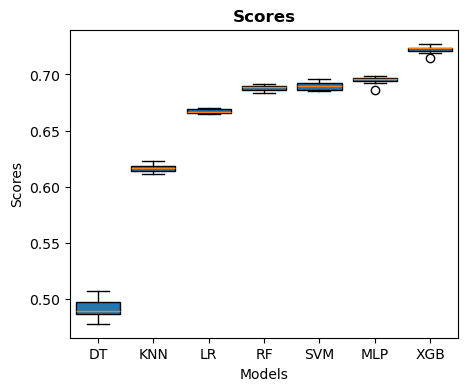

In [129]:
labels = ['KNN', 'DT', 'RF', 'SVM', 'XGB', 'MLP', 'LR']
sorted_indices = np.argsort(medias)

sorted_scores = [scoreslist2[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

plt.figure(figsize=(5, 4))
plt.boxplot(sorted_scores, labels=sorted_labels, patch_artist=True, notch=False, widths=0.8)

# Adicionando títulos e rótulos
plt.title('Scores', fontweight = 'bold')
plt.xlabel('Models')
plt.ylabel('Scores')

# Exibindo o gráfico
plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/boxplot.pdf')
plt.show()

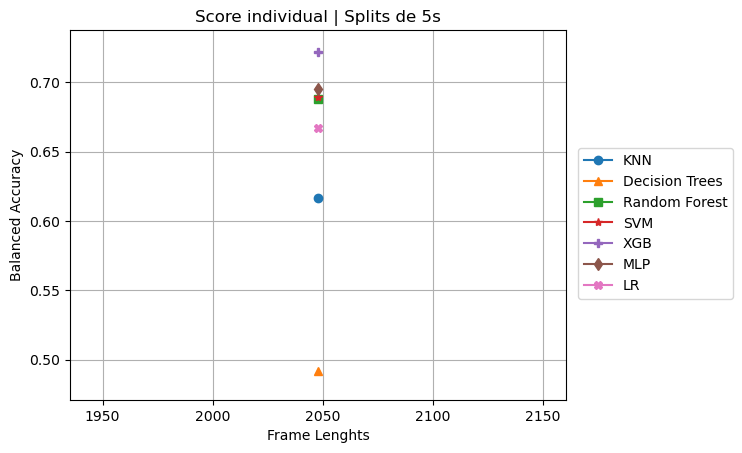

In [53]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [2048]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.15)

plt.legend( bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Score individual | Splits de 5s')

# Nome do arquivo pra salvar
plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/results.pdf')
plt.show()

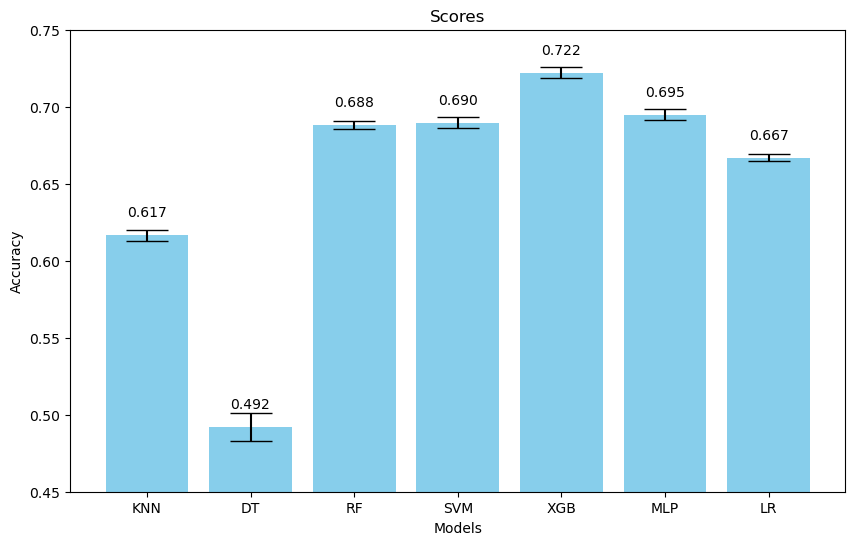

In [83]:
medias = [arr.item() for arr in scoresmeans]
desvios = [arr.item() for arr in scoressds]


labels = ['KNN', 'DT', 'RF', 'SVM', 'XGB', 'MLP', 'LR']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, medias, yerr=desvios, capsize=15, color='skyblue')

for bar, media in zip(bars, medias):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{media:.3f}', ha='center', va='bottom', fontsize=10)

# Adicionando títulos e rótulos
plt.ylim([0.45, 0.75])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Scores')

plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/results.pdf')
plt.show()

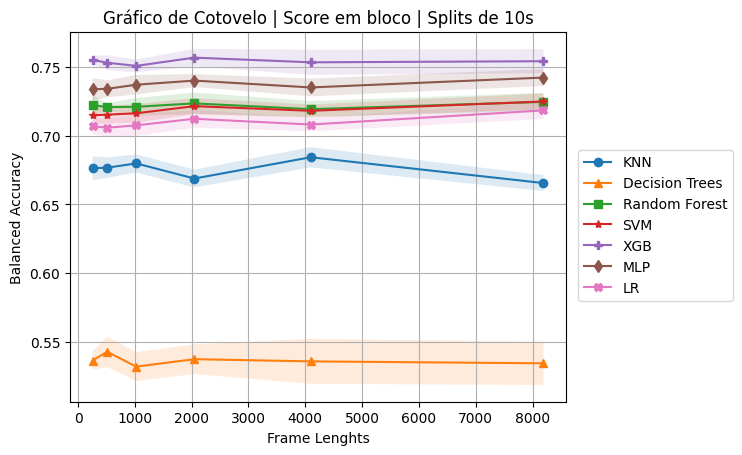

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeansB)):
  plt.plot(frame_lenghts, scoresmeansB[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeansB[i] + scoressdsB[i], scoresmeansB[i] - scoressdsB[i], alpha = 0.15)

plt.legend(bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo | Score em bloco | Splits de 10s')

# Nome do arquivo pra salvar
plt.savefig('F:/Documentos/UTFPR/IC/csvs/ft2/10s/score_bloco_st.pdf')
plt.show()

In [ ]:
means_3s_ind = []
means_3s_ind.append(scoresmeans)
means_3s_b = []
means_3s_b.append(scoresmeansB)

In [ ]:
print(means_3s_b)
print(means_3s_ind)
print(means_5s_ind)
print(means_5s_b)
print(means_10s_ind)
print(means_10s_b)

[[array([0.7  , 0.699, 0.698, 0.704, 0.699, 0.705]), array([0.606, 0.587, 0.624, 0.59 , 0.629, 0.63 ]), array([0.74 , 0.736, 0.743, 0.746, 0.727, 0.735]), array([0.754, 0.753, 0.753, 0.751, 0.744, 0.751]), array([0.779, 0.782, 0.786, 0.79 , 0.784, 0.777]), array([0.754, 0.767, 0.767, 0.769, 0.764, 0.769]), array([0.721, 0.725, 0.728, 0.728, 0.734, 0.743])]]
[[array([0.574 , 0.5721, 0.5731, 0.5783, 0.5803, 0.5741]), array([0.4748, 0.4656, 0.4843, 0.4775, 0.4896, 0.487 ]), array([0.6687, 0.6658, 0.6739, 0.6725, 0.6667, 0.6674]), array([0.6789, 0.6786, 0.6792, 0.6839, 0.6791, 0.6859]), array([0.7009, 0.7015, 0.7112, 0.7134, 0.7041, 0.7063]), array([0.6843, 0.6847, 0.6847, 0.6868, 0.687 , 0.691 ]), array([0.6595, 0.6605, 0.6591, 0.6605, 0.6596, 0.6674])]]
[[array([0.60533333, 0.60533333, 0.60783333, 0.61783333, 0.61216667,
       0.613     ]), array([0.491     , 0.48966667, 0.496     , 0.49566667, 0.49883333,
       0.50133333]), array([0.679     , 0.681     , 0.68533333, 0.69066667, 0.681

In [ ]:
ind_3s = [elemento for array in means_3s_ind[0] for elemento in array]
b_3s = [elemento for array in means_3s_b[0] for elemento in array]

ind_5s = [elemento for array in means_5s_ind[0] for elemento in array]
b_5s = [elemento for array in means_5s_b[0] for elemento in array]

ind_10s = [elemento for array in means_10s_ind[0] for elemento in array]
b_10s = [elemento for array in means_10s_b[0] for elemento in array]


NameError: name 'means_3s_ind' is not defined

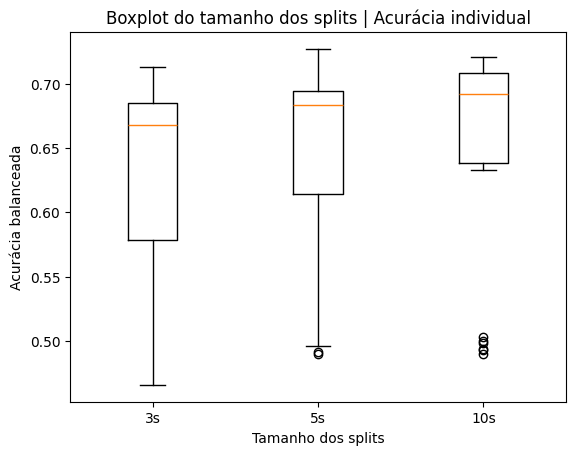

In [ ]:
plt.boxplot([ind_3s, ind_5s, ind_10s], labels=["3s", "5s", "10s"])
plt.xlabel("Tamanho dos splits")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho dos splits | Acurácia individual")
plt.savefig('boxplot_splits.pdf')
plt.show()

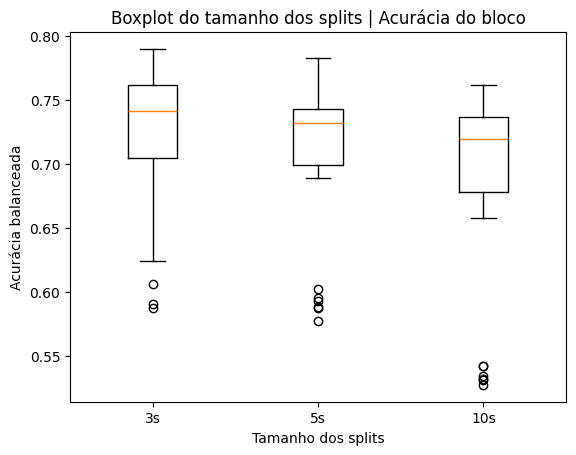

In [ ]:
plt.boxplot([b_3s, b_5s, b_10s], labels=["3s", "5s", "10s"])
plt.xlabel("Tamanho dos splits")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho dos splits | Acurácia do bloco")
plt.savefig('boxplot_splits_b.pdf')
plt.show()

In [ ]:
fls_ind = [[lista[i] for lista in means_3s_ind[0]] for i in range(6)]
fls_b = [[lista[i] for lista in means_3s_b[0]] for i in range(6)]

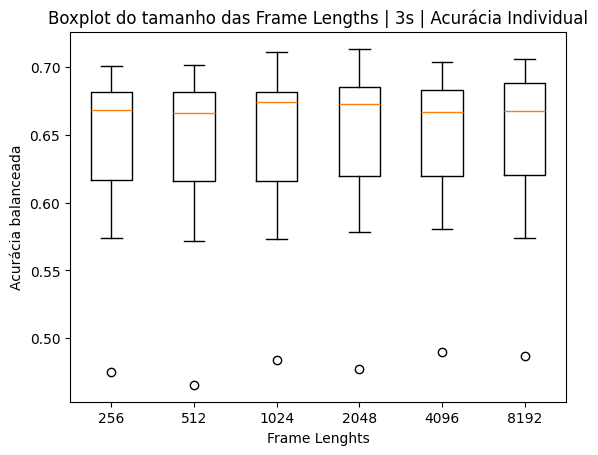

In [ ]:
plt.boxplot(fls_ind, labels=["256", "512", "1024", "2048", "4096", "8192"])
plt.xlabel("Frame Lenghts")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho das Frame Lengths | 3s | Acurácia Individual")
plt.savefig('boxplot_fl3.pdf')
plt.show()

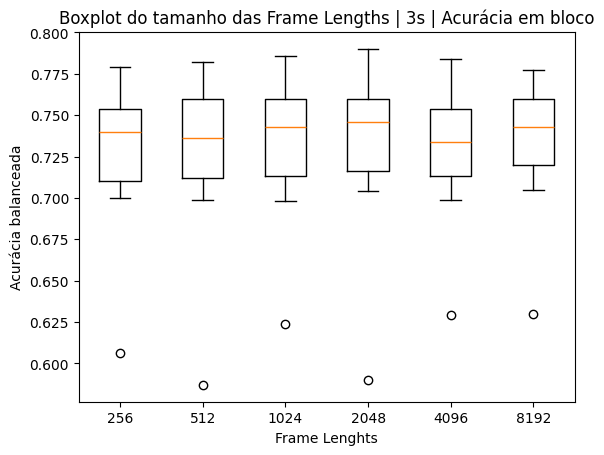

In [ ]:
plt.boxplot(fls_b, labels=["256", "512", "1024", "2048", "4096", "8192"])
plt.xlabel("Frame Lenghts")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho das Frame Lengths | 3s | Acurácia em bloco")
plt.savefig('boxplot_fl3b.pdf')
plt.show()

In [ ]:
from scipy.stats import wilcoxon

statistic, p_value = wilcoxon(np.array(ind_3s), np.array(ind_5s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 3s - 5s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 3s - 5s: 0.0
Valor p: 4.547473508864641e-13
Há evidência estatística de diferença significativa.


In [ ]:

statistic, p_value = wilcoxon(np.array(ind_3s), np.array(ind_10s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 3s - 10s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 3s - 10s: 0.0
Valor p: 4.547473508864641e-13
Há evidência estatística de diferença significativa.


In [ ]:

statistic, p_value = wilcoxon(np.array(ind_5s), np.array(ind_10s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 5s - 10s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 5s - 10s: 38.0
Valor p: 3.6529109078762475e-07
Há evidência estatística de diferença significativa.


In [ ]:
dfbox = pd.DataFrame({'3s individual': ind_3s, '5s individual': ind_5s, '10s individual': ind_10s, '3s em bloco': b_3s, '5s em bloco': b_5s, '10s em bloco': b_10s})

In [ ]:
dfbox.head()
dfbox.to_csv('boxplot_values.csv', index=False)

In [ ]:
def BlockSplit(dataframe, seed, n_songs):


  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  print(dataframe.shape[0])

  print(n_block)

  #used_list = []
  range_list = []
  block_lists = []

  for i in range(10):
    range_list.append(range(i*songs_per_genre, (i+1)*songs_per_genre))

  for k in range(10):
    test_list = []
    definitive_test_list = []

    for i in range(10):
      r = random.sample(range_list[i], n_test)
      # print(range_list[i])
      range_list[i] = [element for element in range_list[i] if element not in r]

      for j in r:
        test_list.append(j)

    test_list.sort()
    print(test_list)
    for i in test_list:
      for j in range(n_block):
        definitive_test_list.append(round((i*n_block)+j))

    print(definitive_test_list)
    block_lists.append(definitive_test_list)

  return block_lists

In [ ]:
test_blocks = BlockSplit(dflist[0] ,42, 1000)

0
[3, 13, 14, 17, 28, 31, 35, 81, 86, 94, 103, 104, 111, 127, 129, 154, 164, 169, 175, 194, 203, 225, 228, 253, 269, 271, 277, 283, 289, 291, 300, 319, 320, 335, 343, 354, 357, 375, 389, 397, 411, 412, 413, 427, 443, 444, 445, 448, 477, 497, 505, 510, 515, 533, 537, 548, 558, 568, 570, 593, 605, 608, 624, 629, 646, 673, 679, 680, 684, 690, 710, 712, 729, 735, 737, 746, 748, 758, 781, 798, 809, 820, 826, 834, 845, 847, 882, 885, 887, 889, 920, 921, 931, 934, 948, 959, 968, 977, 981, 993]
[]
[5, 8, 34, 36, 47, 48, 78, 90, 97, 98, 110, 132, 139, 145, 156, 157, 171, 181, 191, 192, 218, 219, 234, 236, 255, 258, 262, 274, 278, 281, 307, 312, 315, 318, 322, 331, 351, 370, 372, 388, 408, 423, 436, 456, 457, 462, 467, 475, 485, 496, 501, 517, 539, 542, 549, 562, 577, 579, 591, 597, 600, 615, 622, 625, 637, 642, 663, 669, 689, 691, 700, 721, 722, 727, 754, 772, 775, 777, 785, 786, 802, 807, 811, 815, 833, 843, 846, 852, 868, 878, 908, 910, 916, 923, 937, 966, 969, 975, 978, 994]
[]
[33, 38, 52, 

In [ ]:
print(test_blocks)

[]
